In [1166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1167]:
df=pd.read_csv('generated_data.csv')

In [1168]:
# df=df[df.Team==0]

In [1169]:
# https://datascience.stackexchange.com/questions/51615/does-feature-selections-matter-to-decision-tree-algorithms
#  it's common practice to remove some features from datasets for all learning algorithms, like ID fields. 
# These features are especially bad for decision trees, 
# as they usually end up being the feature with the highest information gain (and therefore selected to be split on)
#  while actually containing no generalisable information.
df['Unnamed: 0']

0          0
1          1
2          2
3          3
4          4
        ... 
1137    1137
1138    1138
1139    1139
1140    1140
1141    1141
Name: Unnamed: 0, Length: 1142, dtype: int64

In [1170]:
df=df.drop(['Unnamed: 0'],axis=1)# Unnamed:0 is to be processed

In [1171]:
# Import the necessary modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [1172]:
df["receiverId"]=df["receiverId"].fillna(0) # a sign bit, in order to distinguish

In [1173]:
X = df.loc[:, ~df.columns.isin(["isSucceeded"])]
y = df["isSucceeded"]


In [1174]:
# for timeseriessplit-> consider the timestamp is not informative->discard
# but for really practice->useful, not now, because consider dataset as timeseries, but dataset is small-> consider the dataset as classification task

# from sklearn.model_selection import TimeSeriesSplit
# def time_series_split(X,y):
#     ts_split = TimeSeriesSplit(n_splits=3)

#     # Define the features and target variable
    
#     for train_index, test_index in ts_split.split(df):
#     # Get the training and validation sets
#         X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
#         y_train,y_test=y[train_index],y[test_index]

#         df_train, df_test = df.iloc[train_index,:], df.iloc[test_index,:]
#     return X_train, X_test, y_train, y_test,df_train, df_test

# # note: some feature are generated for example grouby should seperate from train and test dataset

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test,df_train, df_test= time_series_split(X, y) 

# # not so good to split time series data like this way->done, using TimeSeriesSplit->done

In [1198]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# this kind of method would lead to a situation that play_id appears in train, but not in test,so we don' have history of play
# -> not practical
# ->assume we have history of each player, our model only accept player with known history-> stratify

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df[['Player_id','isSucceeded']]) # former proven history variety, later proven target variety

# X_train, X_test, y_train, y_test = train_test_split(X, y)

In [1199]:
df_train=pd.concat([X_train, y_train], axis=1)
df_test= pd.concat([X_test, y_test], axis=1)

In [1200]:
# the receivedId also have an influence, but if has a receiverId, then the pass rate is 100%, so calcuated pass rate for each receiverId is useless as below
# useless -> done

# def added_X_train_test_receiver(df_train,X_train,X_test):
#     data_dict=df_train.groupby(['receiverId']).mean('isSucceeded')['isSucceeded'].to_dict()

#     def add_receiver_rate_train(df): # note player_id and success_rate is one vs one, have no information, but will have information on the test data!!!
#         df['succeed_rate_rec']=df['receiverId'].map(lambda x:data_dict[x])
#         return df

#     def use_lambda(x):
#         import math
#         if x==0: return np.mean(list(data_dict.values()))
#         elif x in data_dict.keys(): # althrough keys() has x==0
#             return data_dict[x]
#         else: return np.mean(list(data_dict.values()))
#     def add_receiver_rate_test(df):
#         df['succeed_rate_rec']=df['receiverId'].map(lambda x:use_lambda(x))
#         return df

#     return add_receiver_rate_train(X_train),add_receiver_rate_test(X_test)
    
# X_train,X_test=added_X_train_test_receiver(df_train,X_train,X_test)
# X_train.succeed_rate_rec.unique() # for test the conclusion above

In [1201]:
# count pair (receiverId and playId)

def added_X_train_test_pair(df_train,X_train,X_test):
    data_dict=df_train.groupby(['receiverId','Player_id']).sum('isSucceeded')['isSucceeded'].to_dict()

    def use_lambda(df):
        import math
        if (df["receiverId"],df['Player_id']) in data_dict.keys() and df["receiverId"]!=0:
            return data_dict[(df["receiverId"],df['Player_id'])]
        return 0

    def add_pair_rate_train(df): 
        df['pair_count']=df.apply(use_lambda,axis=1)
        return df

    def add_pair_rate_test(df):
        df['pair_count']=df.apply(use_lambda,axis=1)
        return df

    return add_pair_rate_train(X_train),add_pair_rate_test(X_test)
    
X_train,X_test=added_X_train_test_pair(df_train,X_train,X_test)

X_test.pair_count.sum() # result is more than 200, so a good idea at least

516

In [1202]:
def add_count_player_id(X_train,X_test):
    pass_dict=df_train.groupby(['Player_id']).count()['posX_passer'].to_dict()
    def add_success_count_train(df): # note player_id and success_rate is one vs one, have no information, but will have information on the test data!!!
        df['succeed_count']=df['Player_id'].map(lambda x:pass_dict[x])
        return df
    def use_lambda(x):
        import math
        if x in pass_dict.keys():
            return pass_dict[x]
        return np.mean(list(pass_dict.values()))
    def add_success_rate_test(df):
        df['succeed_count']=df['Player_id'].map(lambda x:use_lambda(x))
        return df
    return add_success_count_train(X_train),add_success_rate_test(X_test)
    
X_train,X_test=add_count_player_id(X_train,X_test)

In [1203]:
def add_success_rate(df_train,X_train,X_test):
    data_dict=df_train.groupby(['Player_id']).mean('isSucceeded')['isSucceeded'].to_dict()

    def add_success_rate_train(df): # note player_id and success_rate is one vs one, have no information, but will have information on the test data!!!
        df['succeed_rate']=df['Player_id'].map(lambda x:data_dict[x])
        return df
    
    def use_lambda(x):
        import math
        if x in data_dict.keys():
            return data_dict[x]
        return np.mean(list(data_dict.values()))
    def add_success_rate_test(df):
        df['succeed_rate']=df['Player_id'].map(lambda x:use_lambda(x))
        return df
    return add_success_rate_train(X_train),add_success_rate_test(X_test)
X_train,X_test=add_success_rate(df_train,X_train,X_test)

In [1204]:
def add_zone_rate(df_train,X_train,X_test):
    # generate feature based on received_id and also zone
    zone_dict=df_train.groupby(['Player_id','Zone']).mean('isSucceeded')['isSucceeded'].to_dict()
    # df['zone_rate']=df[['Player_id','Zone']].map(lambda x:zone_dict[(x[0],x[1])]) this can't work, map can only used in series, use apply instead
    def use_zone_lambda_train(df):
        return zone_dict[(df["Player_id"],df['Zone'])]
    def add_zone_rate_train(df): # note player_id and success_rate is one vs one, have no information, but will have information on the test data!!!
        df['zone_rate']=df[['Player_id','Zone']].apply(use_zone_lambda_train,axis=1)
        return df

    def use_zone_lambda_test(df):
        import math
        if (df["Player_id"],df['Zone']) in zone_dict.keys():
            return zone_dict[(df["Player_id"],df['Zone'])]
        else:
            sub_dict = {key: value for key, value in zone_dict.items() if key[1]== df['Zone']}
            return np.mean(list(sub_dict.values()))
    def add_zone_rate_test(df):
        df['zone_rate']=df[['Player_id','Zone']].apply(use_zone_lambda_test,axis=1)
        return df
    return add_zone_rate_train(X_train),add_zone_rate_test(X_test)
X_train,X_test=add_zone_rate(df_train,X_train,X_test)



In [1205]:
from sklearn.metrics import matthews_corrcoef

def get_dummy_score(X_train, X_test, y_train, y_test):
    from sklearn.dummy import DummyClassifier


    # Create an instance of the DummyClassifier class
    dummy_classifier = DummyClassifier(strategy='most_frequent')

    # Fit the DummyClassifier instance to the training data
    dummy_classifier.fit(X_train, y_train)

    y_pred=dummy_classifier.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print("f1=",f1)
get_dummy_score(X_train, X_test, y_train, y_test)

f1= 0.8373983739837398


In [1206]:
# from imblearn.over_sampling import RandomOverSampler, SMOTE
# def over_sampler(X,y):
#     # Create an instance of the RandomOverSampler class
#     random_over_sampler = RandomOverSampler()

#     # Create an instance of the SMOTE class
#     smote = SMOTE()

#     # Fit the RandomOverSampler to the data
#     X_resampled, y_resampled = random_over_sampler.fit_resample(X, y)

#     # Fit the SMOTE to the data
#     X,y = smote.fit_resample(X_resampled, y_resampled)
#     return X,y
# X,y=over_sampler(X,y) # for archieved

In [1207]:
X_train=X_train.drop(['receiverId'],axis=1)
X_test=X_test.drop(['receiverId'],axis=1)

In [1208]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.svm import SVC
# classifier= DecisionTreeClassifier()
# classifier.fit(X_train, y_train)

# # Obtain the feature importances
# importances = classifier.feature_importances_

# # Create a plot of the feature importances
# plt.figure()
# plt.bar(X_train.columns, importances)
# plt.xticks(rotation=90)
# plt.xlabel('Feature index')
# plt.ylabel('Feature importance')
# plt.show()


# # Create an instance of the SelectFromModel class
# feature_selector = SelectFromModel(classifier,threshold='1*mean')

# # Fit the SelectFromModel instance to the datadd
# feature_selector.fit(X_train, y_train)
# # Get the selected features
# X_train_selected= feature_selector.transform(X_train)
# X_test_selected=feature_selector.transform(X_test)

# conclusion: this method will set pair_count=1, other all is zero, so just select one feature, not practical!->discard

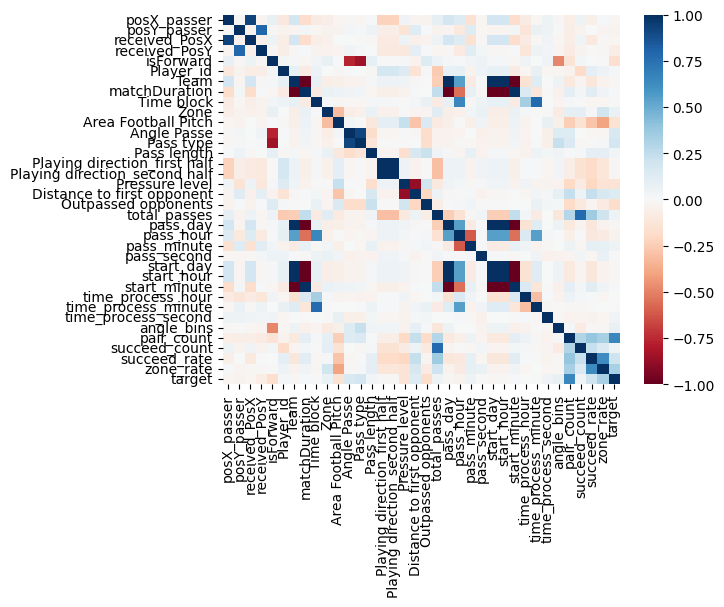

In [1209]:
def plot_corr(X_train,y_train):
    import seaborn as sns
    import copy
    df_plot=copy.deepcopy(X_train)
    df_plot['target'] = copy.deepcopy(y_train)
    corr = df_plot.corr()
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap="RdBu")
plot_corr(X_train,y_train)

In [1210]:
import copy
X_train_b=copy.deepcopy(X_train)
X_test_b=copy.deepcopy(X_test)

In [1211]:
X_train=copy.deepcopy(X_train_b)
X_test=copy.deepcopy(X_test_b)

In [1212]:
# from sklearn.feature_selection import SelectKBest, chi2,f_classif
# # chi2 ValueError: Input X must be non-negative.-> discard, can only be used when dataset is non-negative
# feature_selector = SelectKBest(score_func=f_classif, k=10)
# feature_selector.fit(X_train, y_train)

# X_train= feature_selector.transform(X_train)
# X_test=feature_selector.transform(X_test)

# print("X_train.shape=",X_train.shape)
# print("X_test.shape=",X_test.shape)

In [1213]:
# Import the necessary libraries and models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# insight: classifiers are just above the dummy model or even above, try to extract more features

# Define a dictionary of classification models
models = {
    "logistic_regression": LogisticRegression(),
    "support_vector_machine": SVC(),
    "k_nearest_neighbors": KNeighborsClassifier(),
    "decision_tree": DecisionTreeClassifier(),
    "random_forest": RandomForestClassifier(),
    "ada_boost": AdaBoostClassifier(),
    "gradient_boosting": GradientBoostingClassifier(),
    "xg_boost": XGBClassifier(),
    "bagging": BaggingClassifier(),
    "extra_trees": ExtraTreesClassifier(),
    "mlp": MLPClassifier(),
    "gaussian_process": GaussianProcessClassifier(),
    "quadratic_discriminant_analysis": QuadraticDiscriminantAnalysis()
}


In [1214]:
# Loop through the models and evaluate each one
for name, model in models.items():
    print(name,":")
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print("f1=",f1)

# note: majority of models, the score is bad than dummy model, which means there are so many noise.

logistic_regression :
f1= 0.8373983739837398
support_vector_machine :
f1= 0.8373983739837398
k_nearest_neighbors :
f1= 0.817391304347826
decision_tree :
f1= 0.8894878706199462
random_forest :
f1= 0.8894878706199462
ada_boost :
f1= 0.8894878706199462
gradient_boosting :
f1= 0.8894878706199462
xg_boost :
f1= 0.8894878706199462
bagging :
f1= 0.8894878706199462
extra_trees :
f1= 0.9090909090909091
mlp :
f1= 0.01923076923076923
gaussian_process :
f1= 0.7383863080684597
quadratic_discriminant_analysis :
f1= 0.8924731182795699


/Users/horus_liang/opt/anaconda3/envs/intro_to_ds/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [1215]:
# Define the parameter grid
param_grid = {
    'n_estimators': [2,5,10,50,100],
    'max_depth': [3,5,10],
}

from sklearn.model_selection import RandomizedSearchCV

# Create an instance of the Random Forest classifier
classifier = RandomForestClassifier()

# Create an instance of the RandomizedSearchCV class
random_search = RandomizedSearchCV(classifier, param_grid,cv=5,scoring='f1') 

# Fit the RandomizedSearchCV to the data
random_search.fit(X_train, y_train)

print(random_search.best_score_) # 1.0

classifier = random_search.best_estimator_
y_pred=classifier.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("f1=",f1) # 0.47

# !!! conclusion: this kind of method is not correct, cv=ts_split, the best estimator would be the one tuning the parameter based on validation dataset,leading to overfitting, not generalization.
# so note: maybe the model is too complex ?->discard this model->done
# even through cv has test dataset, but still can overfit, becase overfit is the situation when strong model and less test score, less test data

1.0
f1= 0.8894878706199462


In [37]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Create an instance of the RandomOverSampler class
random_over_sampler = RandomOverSampler()

# Create an instance of the SMOTE class
smote = SMOTE()

# Fit the RandomOverSampler to the data
X_resampled, y_resampled = random_over_sampler.fit_resample(X, y)

# Fit the SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(X, y)


from sklearn.model_selection import RandomizedSearchCV
# Create an instance of the Random Forest classifier
classifier = RandomForestClassifier()

# Create an instance of the RandomizedSearchCV class
random_search = RandomizedSearchCV(classifier, param_grid)

# Fit the RandomizedSearchCV to the data
random_search.fit(X_resampled, y_resampled)

# Print the best parameters
print(random_search.best_params_)

print(random_search.best_score_)


{'n_estimators': 1000, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 3}
0.4285341738428922


In [43]:
get_dummy_score(X_resampled, y_resampled)

accuracy= 0.47549019607843135
